# 0. Import packages

In [1]:
import firedrake
import numpy as np
import pickle as pkl
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl
import tqdm
import emcee
import corner
import itertools
import xarray
import dtscalibration
import glob
from rasterio.plot import show
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os
import sys
from pyproj import Transformer
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scripts.AH_temp_funcs import *
import rasterio

%matplotlib widget

# 0.1 Load necessary files

In [2]:
### Load the GPS velocities
gps_velocities = pd.read_csv('../GPS_velocities/24-25_velocities-good.csv')

### Load boreholes
borehole_locations = pd.read_csv('../Borehole_Locations/Borehole_locations_DTS.csv')
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3031", always_xy=True)
transformed_x, transformed_y = transformer.transform(borehole_locations['E'], borehole_locations['S'])

### Load image data

with rasterio.open('../imagery/LIMA_virtual_Mosaic_15m.tif') as src1:
    image_data = src1.read()

# 1. Make a synthetic mesh

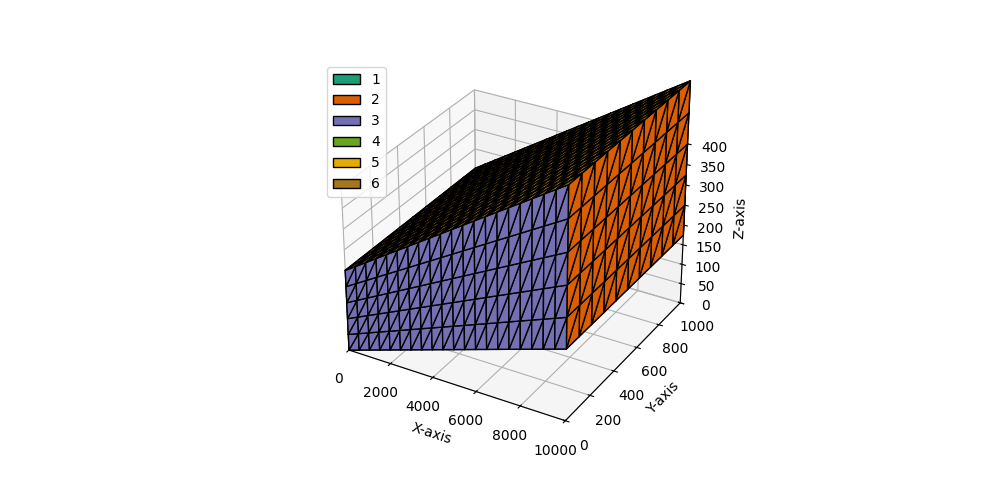

In [3]:
nx, ny, nz = 20, 10, 5

initial_mesh = firedrake.UnitCubeMesh(nx, ny, nz)

x, y, z = firedrake.SpatialCoordinate(initial_mesh)

Lx = Constant(10000) # How long we want the x to be
Ly = Constant(1000) # How wide we want y to be
Lz = Constant(200) # Initial thickness

bed_start = Constant(0.0) # Where the bed starts
bed_slope = Constant(1 * np.pi / 180) # bed slope (first term given as degrees)
surf_slope = Constant(2 * np.pi / 180) # surface slope (first term given as degrees)

# Physical x and y
X = Lx * x
Y = Ly * y


# Compute bed and surface elevation
bed = bed_slope * X
surf = Lz + surf_slope * X

# Interpolate z between bed and surface
z_new = bed + z * (surf - bed)

expr = firedrake.as_vector([Lx * x, 
                            Ly * y, 
                            z_new])


Vc = initial_mesh.coordinates.function_space()
X = firedrake.Function(Vc).interpolate(expr)
mesh = firedrake.Mesh(X)

x, y, z = firedrake.SpatialCoordinate(mesh)
element = firedrake.FiniteElement("CG", "tetrahedron", 1)
V = firedrake.FunctionSpace(mesh, element)

ax = plt.figure(figsize=[10,5]).add_subplot(projection='3d')


firedrake.triplot(mesh,axes=ax)

ax.autoscale()
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

ax.set_xlim([0, 10000])
ax.set_ylim([0, 1000])
ax.set_zlim([0, 400])

plt.legend()
plt.show()

# 2. Set up the finite element model

## 2.0 Create the functions and set up the momentum equation

In [4]:
μ = Constant(5e15) #Ice


pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 3)
Y = velocity_space * pressure_space
flow = firedrake.Function(Y)
u, p = firedrake.split(flow)
v, q = firedrake.TestFunctions(flow.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, 0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

## 2.1 create the boundary conditions

In [5]:
face_ids = [6, 5, 1, 2, 3, 4]

bc_stokes = []
for id in face_ids:
    if id == 6: pass # Skip the top face for now (free flow)
    else:
        bc = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0, 0)), id) # No flow on the boundaries
        bc_stokes.append(bc)

## 2.2 Do the stokes solve

In [6]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, flow, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}

stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

## 2.3 Plot the solution of the stokes solve

### 2.3.1 This gets the bed coordinates

In [7]:
from collections import defaultdict

min_z = defaultdict(lambda: float("inf"))

for x_coord_mesh, y_coord_mesh, z_coord_mesh in mesh.coordinates.dat.data[:]:
    if z_coord_mesh < min_z[(x_coord_mesh, y_coord_mesh)]:
        min_z[(x_coord_mesh, y_coord_mesh)] = z_coord_mesh

bed_coordinates = [[x_coord_mesh, y_coord_mesh, z_coord_mesh] for (x_coord_mesh, y_coord_mesh), z_coord_mesh in min_z.items()]
bed_coordinates = np.array(bed_coordinates)

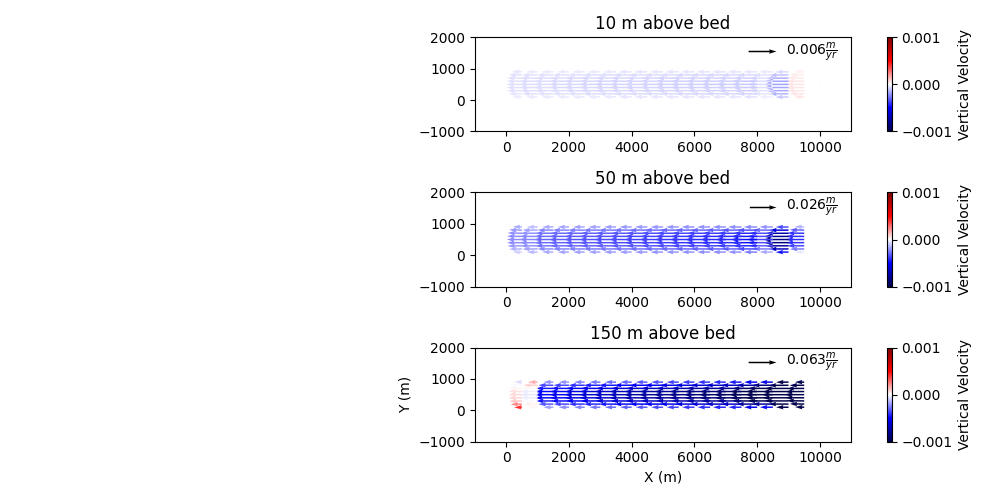

In [9]:


cross_sections = [10,50,150]

fig, axes = plt.subplots(len(cross_sections),1,figsize=[10,5])

for n,m_above_bed in enumerate(cross_sections):
    vel_cross = []
    vel_cross_coords = []

    ### If the DEM includes some nonesense pixels in it, you need this block ##########
    # for x_coord, y_coord, z_coord in zip(xi[:,0], xi[:,1], extruded_bed.dat.data_ro[:]):
    #     if 1998.99 < z_coord < 1999.01:
    #         continue
    #     else:
    #         vel_cross.append(y.at(x_coord, y_coord, z_coord+m_above_bed)[0])
    #         vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
    #####################################################################################

    ### If the DEM is perfectly rectangular, than you can do this block ####
    for x_coord, y_coord, z_coord in zip(bed_coordinates[:,0], bed_coordinates[:,1], bed_coordinates[:,2]):
        
        try:
            vel_cross.append(flow.at(x_coord, y_coord, z_coord+m_above_bed)[0])
            vel_cross_coords.append([x_coord, y_coord, z_coord+m_above_bed])
        except:
            continue

    #########################################


    vel_cross = np.asarray(vel_cross)
    vel_cross_coords = np.asarray(vel_cross_coords)

    norm = mcolors.Normalize(vmin=-0.001, vmax=0.001)
    cmap = plt.cm.seismic
    colors = cmap(norm(vel_cross[:,2]*spy))

    show(image_data,ax=axes[n],transform=src1.transform)
    Q = axes[n].quiver(vel_cross_coords[:,0], vel_cross_coords[:,1], vel_cross[:,0]*spy, vel_cross[:,1]*spy, scale = None, color=colors)

    axes[n].set_xlim([vel_cross_coords[:,0].min()-1000, vel_cross_coords[:,0].max()+1000])
    axes[n].set_ylim([vel_cross_coords[:,1].min()-1000, vel_cross_coords[:,1].max()+1000])

    axes[n].set_title(str(m_above_bed)+' m above bed')
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Needed only to satisfy colorbar creation
    cbar = plt.colorbar(sm, ax=axes[n], fraction=0.026, pad=0.04)
    cbar.set_label('Vertical Velocity')

    max_val = round(np.max(np.sqrt((vel_cross[:,0]*spy)**2+(vel_cross[:,1]*spy)**2)),3)
    axes[n].scatter(transformed_x,transformed_y, marker='.',color='black', label='Boreholes')
    max_val_str = str(max_val)
    qk = axes[n].quiverkey(Q, 0.8, 0.85, max_val, max_val_str+r'$\frac{m}{yr}$', labelpos='E', coordinates='axes', color='black')
    axes[n].quiver(gps_velocities['x'], gps_velocities['y'], 
                   gps_velocities['u'], gps_velocities['v'], 
                   scale = None, label='GPS velocities')
    # axes[n].legend()


axes[2].set_xlabel('X (m)')
axes[2].set_ylabel('Y (m)')

plt.tight_layout()

# 3. Include temperature in the model

## 3.1 Add temperature functions

In [10]:
from ufl import Measure
dx = ufl.Measure("dx", domain=mesh)

V = firedrake.FunctionSpace(mesh, "CG", 1)
# V = firedrake.FunctionSpace(mesh, extruded_element)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)

geo_flux = 0.05 # W/m^2 
k = Constant(2.22)  # W / m C

geothermal_flux = -geo_flux*ϕ  * ds((5))
F_diffusion = k*inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

F = F_diffusion + F_advection + geothermal_flux

## 3.2 Add temperature boundary conditions

In [11]:
T_mean = -31 #average temp (C)

temperature_expr = T_mean - (z - 300)*.01

surface_temp_bc = firedrake.DirichletBC(V, temperature_expr, 6)

## 3.3 Solve for the temperature field

In [12]:
firedrake.solve(F == 0, T, [surface_temp_bc])

## 3.4 Plot temp profile at a given point

### 3.4.1 Get the z values we want to try

In [13]:
z_vals = mesh.coordinates.dat.data_ro[:,2]
depth_values = np.arange(z_vals.min(), z_vals.max(), 5)

### 3.4.2 Get the temperature profile of the point we want in the ablation zone

In [14]:

x_bore, y_bore = 1000, 500

temp_coords = []
temp_vals = []
for z_bore in depth_values:
    try:
        temp = T.at(x_bore, y_bore, z_bore)
        temp_coords.append([x_bore, y_bore, z_bore])
        temp_vals.append(temp)
    except:
        continue

### 3.4.3 Plot the synthetic borehole temperature

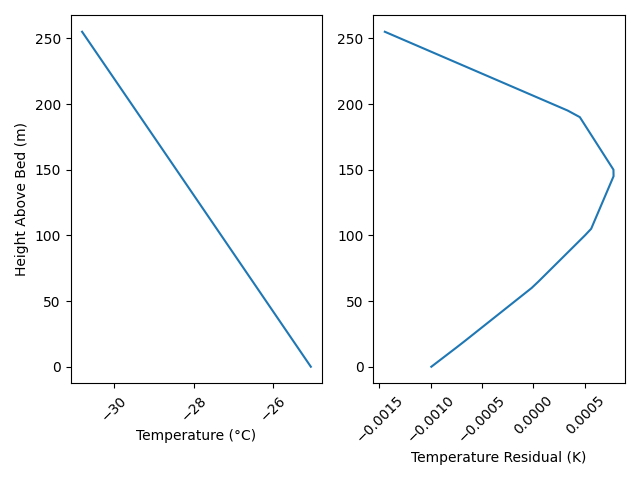

In [15]:
fig, ax = plt.subplots(1,2)

ax[0].plot(temp_vals,np.array(temp_coords)[:,2])
ax[1].plot(scipy.signal.detrend(temp_vals),np.array(temp_coords)[:,2])

ax[0].set_ylabel('Height Above Bed (m)')
ax[0].set_xlabel('Temperature (°C)')
ax[1].set_xlabel('Temperature Residual (K)')

ax[0].tick_params(axis='x', labelrotation = 45)
ax[1].tick_params(axis='x', labelrotation = 45)
plt.tight_layout()